In [1]:
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot

import os
import time
import networkx as nx
import pandas as pd
import numpy as np
from IPython.display import Image

# Load Data
First, we must load the somatic mutation and network data for running pyNBS along with any additional parameters we would like to change in the algorithm performance.

### Load molecular network
The network file is a 2-column text file representing an unweighted network. Each row represents a single edge in the molecular network.    
  
Notes about the network file:  
 - The default column delimiter is a tab character '\t' but a different delimiter can be defined by the user here or in the parameter file with the "net_filedelim" parameter.
 - The network must not contain duplicate edges (e.g. TP53\tMDM2 is equivalent to MDM2\tTP53)
 - The network must not contain self-edges (e.g. TP53\tTP53)
 - Only the first two columns of a network file are read as edges for the network, all other columns will be ignored.
 - The load_network function also includes options to read in edge- or label-shuffled versions of the network, but by default, these options are turned off.
 
An excerpt of the first five rows of the PID network file is given below:  
```
A1BG	A2M
A1BG	AKT1
A1BG	GRB2
A1BG	PIK3CA
A1BG	PIK3R1
```

In [3]:
# The only required parameter for this function is the network file path

network_filepath = './Example_Notebook_Data/Network_Files/HM90.sif'
network = dit.load_network_file(network_filepath)

Network File Loaded: ./Example_Notebook_Data/Network_Files/HM90.sif


### Load binary somatic mutation data
The binary somatic mutation data file can be represented in two file formats:  
The default format for the binary somatic mutation data file is the ```list``` format. This file format is a 2-column csv or tsv list where the 1st column is a sample/patient and the 2nd column is a gene mutated in the sample/patient. There are no headers in this file format. Loading data with the list format is typically faster than loading data from the matrix format.The following text is the list representation of the matrix above.
```
TCGA-04-1638	A2M
TCGA-23-1029	A1CF
TCGA-23-2647	A2BP1
TCGA-24-1847	A2M
TCGA-42-2589	A1CF
```

The ```matrix``` binary somatic mutation data format is the format that data for this example is currently represented. This file format is a binary csv or tsv matrix with rows represent samples/patients and columns represent genes.  The following table is a small excerpt of a matrix somatic mutation data file:  

||A1CF|A2BP1|A2M|
|-|-|-|-|
|TCGA-04-1638|0|0|1|
|TCGA-23-1029|1|0|0|
|TCGA-23-2647|0|1|0|
|TCGA-24-1847|0|0|1|
|TCGA-42-2589|1|0|0|



In [4]:
# The only required file here is the file path to the somatic mutation data
# However, in this example, the data is not formatted in the default 2-column tab-separated list, so we set the
# file loading parameters explicitly below

sm_data_filepath = './Example_Notebook_Data/Mutation_Files/OV_sm_mat_Hofree.csv'
sm_mat = dit.load_binary_mutation_data(sm_data_filepath, filetype='matrix', delimiter=',')

### Setting result output options
The following code is completely optional for the user. Allows users to pre-define a directory to save intermediate and final results to and establishes a file name prefix for those files in the output directory folder. Also creates the output directory if it does not already exist. The result of this cell will be a dictionary that can be passed optionally to functions to save results.

**Note:** The key assumption here is that if the user passes **save_args to the function that contains a valid file path to a directory in ```outdir```, the result of that particular call of the function will be saved to the given ```outdir```

In [5]:
# Optional: Setting the output directory for files to be saved in
outdir = './Results/Hofree_OV/'

# Optional: Creating above output directory if it doesn't already exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Optional: Setting a filename prefix for all files saved to outdir
job_name = 'HofreeOV'

# Constructs dictionary to be passed as "save_args" to functions if output to be saved
save_args = {'outdir': outdir, 'job_name': job_name}

# Construct regularization graph for use in network-regularized NMF
In this step, we will construct the graph used in the network-regularized non-negative matrix factorization (netNMF) step of pyNBS. This network is a K-nearest neighbor (KNN) network constructed from the network influence matrix (Vandin et al 2011*) of the molecular network being used to stratify tumor samples. The graph laplacian of this KNN network (knnGlap) is used as the regularizer in the following netNMF steps. This step uses the `network_inf_KNN_glap()` function in the pyNBS_core module. The function constructs the knnGlap with the following steps:  
  
__Steps to construct knnGlap:__
1. Construct the network influence matrix as described by Vandin et al 2011*
> i. Construct laplacian matrix of the molecular network.  
> ii. Adjust diagonal of the laplacian matrix by small gamma factor (default 0.01)  
> iii. Calculate the inverse of the diagonal-adjusted graph laplacian from (ii) to get the network influence matrix <br> Note: _This method is significantly faster and gives similar results as the original method used previously in Hofree's NBS v0.2.0, which calculated the pseudoinverse of each network component._
2. Construct KNN graph by conneting each node to its k nearest neighbors by influence score (default k is 11)
3. Calculate graph laplacian of this new KNN graph and return it as knnGlap

---
* Fabio Vandin, Eli Upfal, and Benjamin J. Raphael. Journal of Computational Biology. March 2011, 18(3): 507-522. https://doi.org/10.1089/cmb.2010.0265

In [6]:
# Constructing knnGlap
knnGlap = core.network_inf_KNN_glap(network)

##########################################################################################################
# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the KNN graph laplaican to the output directory 'outdir' given above:
# Uncomment and run the following line instead:
# knnGlap = core.network_inf_KNN_glap(network, **save_args)
##########################################################################################################

Graph influence matrix calculated: 15.3742959499 seconds
Graph laplacian of KNN network from influence matrix calculated: 44.2514939308 seconds


# Construct network propagation kernel matrix
Due to the multiple subsampling and propagation steps used in pyNBS, we have found that the algorithm can be significantly sped up for large numbers of subsampling and propagation iterations if a network propagation kernel can be pre-computed. Here we compute this propagation kernel by propagating the all genes in the molecular network independently of one another. The propagation profile of each tumor is then simply the row sums of all genes marked as mutated in each tumor, rather than having to perform the full network propagation step again after each subsampling of the data. Re-propagating at each subsampling step can be time consuming due to the matrix inversion calculation required by our implementation of the network propagation algorithm, which is based on the closed form of the random walk model over networks presented by the HotNet2 paper (Leiserson et al 2015*). This step uses the `network_propagation()` function in the network_propagation module of pyNBS.<br>

The general formulation of the closed form random-walk propagation for a given network: <br>
$$F_t = (1-\alpha)*F_0*(I-\alpha*A)^{-1}$$<br>
$F_0$ here is typically the binary mutation matrix, but for the kernel, it is the same as the identity matrix. A is the normalized adjcency matrix of the molecular network. The normalized adjacency matrix is calculated as $A*D^{-1}$ where D is the row/column-matched diagonalized node degree of the molecular network. $\alpha$ is the network propagation constant, a default value of 0.7 is used here (same as by Hofree), but results may vary if $\alpha$ is changed. Analysis by Hofree et al suggest that setting $\alpha$ between 0.5-0.8 gives relatively stable results.
  
Additional notes about how we perform random-walk based network propagation:  
 - We first separate the molecular network into each connected component and then perform network propagation for each connected component and concatenate the resulting kernel matrices along the diagonal for each subgraph.
 - Our default normalized adjacency matrix is not symmetric, but an option is available to calculate a symmetric degree-normalized adjacency matrix defined as $D^{-0.5} * A * D^{-0.5}$.  
 
---
* Leiserson MDM, Vandin F, Wu H-T, et al. Pan-Cancer Network Analysis Identifies Combinations of Rare Somatic Mutations across Pathways and Protein Complexes. Nature genetics. 2015;47(2):106-114. doi:10.1038/ng.3168.

### Network propagation coefficient
The current network propagation coefficient ($\alpha$) is currently set to 0.7 and must range between 0 and 1. This parameter can be tuned and changing it may have a result on the final propagation results. Previous results from Hofree et al 2013 suggest that values between 0.5 and 0.8 produce relatively robust results, but we suspect that the optimal value may be dependent on certain network properties such as edge density.

In [7]:
# Set or change network propagation coefficient if desired
alpha = 0.7

In [8]:
# Construct identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)

In [9]:
# Construct network propagation kernel
kernel = prop.network_propagation(network, network_I, alpha=alpha)

##########################################################################################################
# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the propagation kernel to the output directory 'outdir' given above,
# Uncomment and run the following two lines instead of the above line:
# save_args['iteration_label']='kernel'
# kernel = prop.network_propagation(network, network_I, alpha=alpha, **save_args)
##########################################################################################################

Performing network propagation with alpha: 0.7
Network Propagation Complete: 132.199929953 seconds


# Subsampling, propagation, and netNMF
After the pre-computation of the regularization graph laplacian and the network propagation kernel, we perform the core steps of the NBS algorithm multiple times (100x here) to produce multiple patient clusters that will be used in the later consensus clustering step. Each patient clustering is performed with the following steps:  
  
__1. Subsample binary somatic mutation data__
>  i. Reduce binary somatic mutation data matrix to only contain columns of genes found in the network.  
>  ii. Sub-sample rows (samples/tumors) and columns (network genes) of the binary somatic mutation matrix. Default is 80% of each axis. This can be changed with the *pats\_subsample\_p* and *gene\_subsample\_p* value in the parameter file/dictionary.  
>  iii. Filter all rows with less than the minimum number of mutations. Default is 10 mutations. This can be changed with the *min\_muts* value in the parameter file/dictionary.  
  
__2. Propagate binary somatic mutation data over network__
>  i. If no network propagation kernel is pre-computed/provided, use the closed form of the random walk model over the full network by subgraphs (HotNet2)  
> ii. If a pre-calculated kernel is provided, calculate individual propagation profiles by calculating the column sums of all genes mutated in the patient for each patient. This method saves a significant amount of time when performing many iterations of these steps.  
  
__3. Quantile normalize the network-smoothed mutation data__
>  i. Sort each patient by gene propagation value  
>  ii. Rank averages for each gene across samples  
>  iii. Assign ranked averages to ranks of each gene for each sample  
  
__4. Use netNMF to decompose network data into k clusters__
>  i. In each iteration, update W and H with network constraints until W and H converge  
> ii. Track reconstruction errors and residuals  
  
These steps are wrapped by the `pyNBS_single()` function, which calls each step above as a different function from the `pyNBS_core module` (with the exception of the network propagation step).

### Number of pyNBS clusters
The default number of clusters constructed by pyNBS is k=3. In this example however, there are 4 clusters. We change that definition explicitly below in the parameters for ```pyNBS_single()```. Other parameters such as the subsampling parameters and the propagation coefficient (when no kernel is pre-computed) can also be changed using \*\*kwargs. \*\*kwargs can also will hold the values of \*\*save_args as seen in previous functions if the user would like to save the resulting dimension reduced patient profiles. All documentation of \*\*kwargs definitions are given in the Github wiki page for ```pyNBS_single```

In [10]:
clusters = 4

### Number of pyNBS iterations
The consensus clustering step of the pyNBS algorithm will improve if the data is subsampled, and re-clustered multiple times. The default number of times we perform the aforementioned operation (```niter```) is 100 times. The number can be reduced for faster run-time, but may produce less robust results. Increasing ```niter``` will increase overall runtime, but should produce more robust cluster assignments during consensus clustering.

In [11]:
# Set the number of times to perform pyNBS core steps
niter = 2

In [12]:
# Optional: Saving the intermediate propagation step (from subsampled data) to file
# save_args['save_prop'] = True

# Run pyNBS 'niter' number of times
Hlist = []
for i in range(niter):
    netNMF_time = time.time()
    # Run pyNBS core steps and save resulting H matrix to Hlist
    Hlist.append(pyNBS_single.NBS_single(sm_mat, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, k=clusters))
    
    ##########################################################################################################
    # Optional: If the user is saving intermediate outputs (propagation results or H matrices), 
    # a different 'iteration_label' should be used for each call of pyNBS_single().
    # Otherwise, the user will overwrite each H matrix at each call of pyNBS_single()
    # Uncomment and run the two lines below to save intermediate steps instead of the previous line
    # save_args['iteration_label']=str(i+1)
    # Hlist.append(pyNBS_single.NBS_single(sm_mat, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, 
    #                                      k=clusters, **save_args))
    ##########################################################################################################
    
    # Report run time of each pyNBS iteration
    t = time.time()-netNMF_time
    print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 132.388656139 seconds
NBS iteration: 2 complete: 136.476912975 seconds


# Consensus Clustering
In order to produce robust patient clusters, the sub-sampling and re-clustering steps as done above are needed. After the patient data is subsampled multiple times (default=100), we perform the following step on each individual clustering result to create a single consensus clustering of all patients.  
  
__Steps for consensus clustering__
1. Assign each patient to a cluster by the argmax column in the 'H' matrix for each netNMF result (termed 'hard cluster assignment')
2. Construct patient x patient co-clustering matrix where each element is the proportion of all clustering iterations where any two patients were assigned to the same cluster.
3. Transform this simiarity matrix into a distance matrix by taking 1-[co_clustering_matrix]
4. Apply hierarchical clustering to the resulting distance matrix from (3) by average linkage and cut the hierarchy at desired depth k (the number of clusters, default is 3) to assign patients to a consensus cluster.

This step uses the consensus_hclust_hard() function in the conensus_clustering module. It accepts a list of pandas dataframes as generated in the previous step. If the H matrices were generated separately and saved to a directory, the user will need to manually import those H matrices into a python list first before passing the list to the function below.

In [14]:
NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, k=clusters, **save_args)

Constructing Hlist: 2 cluster matrices 266 samples
Hlist consensus constructed and sample clusters assigned


# Co-Clustering Map
To visualize the clusters formed by the pyNBS algorithm, we can plot a similarity map using the objects created in the previous step. We will also load data from the original Hofree et al 2013 paper to compare the results of the pyNBS implementation of the algorithm to the results reported in the paper. This step uses the `cluster_color_assign()` and `plot_cc_map()` functions in the `pyNBS_plotting` module.

In [15]:
# First load the cluster assignment data from Hofree 2013 for ovarian cancer patients
orig_Hofree_OV_clust = pd.read_table('./Example_Notebook_Data/Hofree_Results/Hofree_OV_NBS_Results.csv',sep=',',index_col=0)

# Align the pyNBS and Hofree cluster assignments with one another using Pandas
cluster_align = pd.concat([orig_Hofree_OV_clust.iloc[:,0], NBS_cluster_assign], axis=1).dropna(axis=0, how='any').astype(int)
Hofree_OV_clust = cluster_align.iloc[:,0].astype(int)
pyNBS_OV_clust = cluster_align.iloc[:,1].astype(int)

In [16]:
# Assign colors to clusters from Hofree and pyNBS
Hofree_OV_clust_cmap = plot.cluster_color_assign(Hofree_OV_clust, name='Hofree OV Cluster Assignments')
pyNBS_OV_clust_cmap = plot.cluster_color_assign(pyNBS_OV_clust, name='pyNBS OV Cluster Assignments')

# Plot and save co-cluster map figure
plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, row_color_map=Hofree_OV_clust_cmap, col_color_map=pyNBS_OV_clust_cmap, **save_args)

Co-Clustering Map plotted


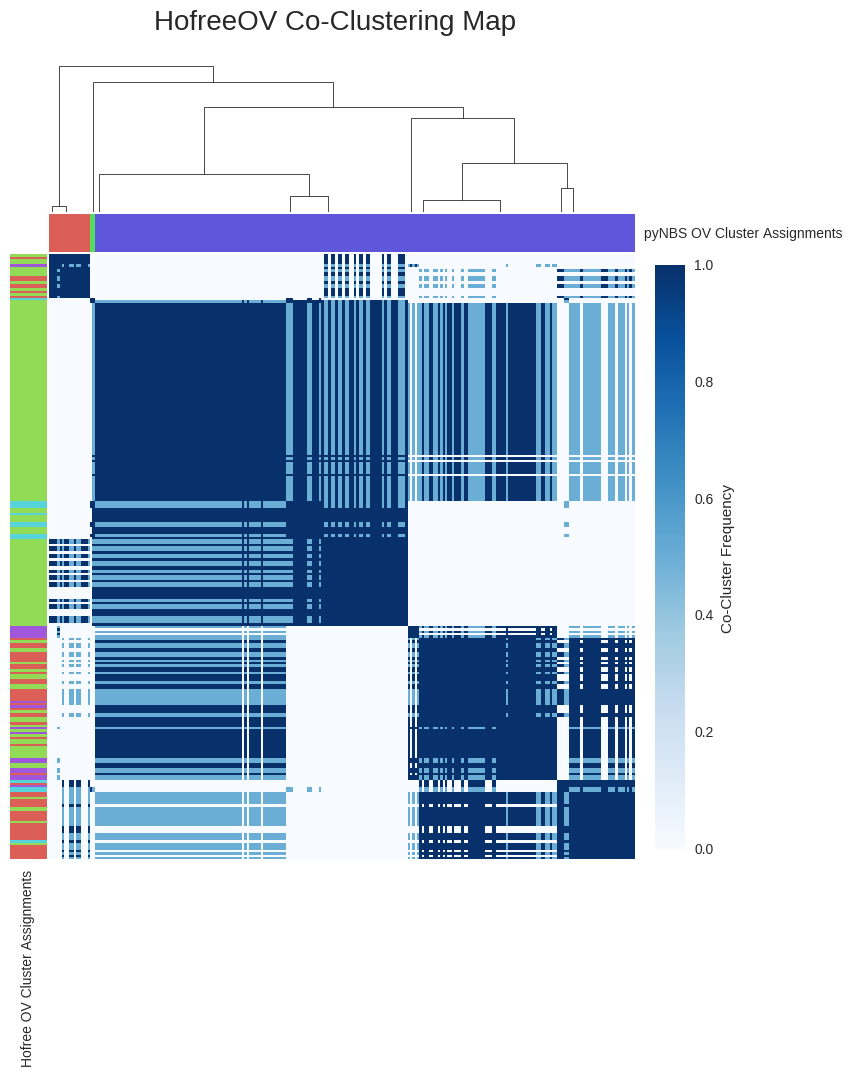

In [17]:
Image(filename = pyNBS_params['outdir']+pyNBS_params['job_name']+'_cc_map.png', width=600, height=600)

# Survival analysis
To determine if the patient clusters are prognostically relevant, we perform a standard survival analysis using a multi-class logrank test to evaluate the significance of survival separation between patient clusters. This data is plotted using a Kaplan-Meier plot using the `cluster_KMplot()` in the `pyNBS_plotting` module. However in order to plot the survival differences between clusters, we will need to load survival data for each patient. This data was extracted from TCGA clinical data. The survival data is given in a 4-column delimited table with the specific headings described below (the columns must be in the same order as shown below). 
  
__Survival Table Column Headers:__
 - `vital_status`: Binary (0/1) value of whether or not the patient is alive (censored). 0 for alive, 1 for dead.
 - `days_to_death`: If the patient has a death event in the `vital_status` column, this is the number of days the patient survived from diagonsis. Otherwise the value is 0 if the patient is still alive.
 - `days_to_last_followup`: If the patient is still alive, this the last time the patient was known to have followed up and was still alive. Otherwise the value is 0 if the patient is dead.
 - `overall_survival`: This is either the days until the patient's death or until their last follow-up. This is the max of the aforementioned previous 2 columns.

The following is an example of a few lines of the Hofree OV survival table:  

||vital_status|days_to_death|days_to_last_followup|overall_survival|
|-|-|-|-|-|
|TCGA-3P-A9WA|0|0|420|420|
|TCGA-59-A5PD|1|624|0|624|
|TCGA-5X-AA5U|0|0|361|361|
|TCGA-04-1331|1|1336|0|1336|
|TCGA-04-1332|1|1247|0|1247|

Note: The default setting for pyNBS is that no survival curves are drawn because the survival data is not a required parameter. The path to valid survival data must be explicitly defined.

/cellar/users/jkhuang/anaconda/lib/python2.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:97: RuntimeWarning: divide by zero encountered in log
  return (np.log(population - deaths) - np.log(population))
/cellar/users/jkhuang/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:225: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


Multi-Class Log-Rank P: 0.178244493018


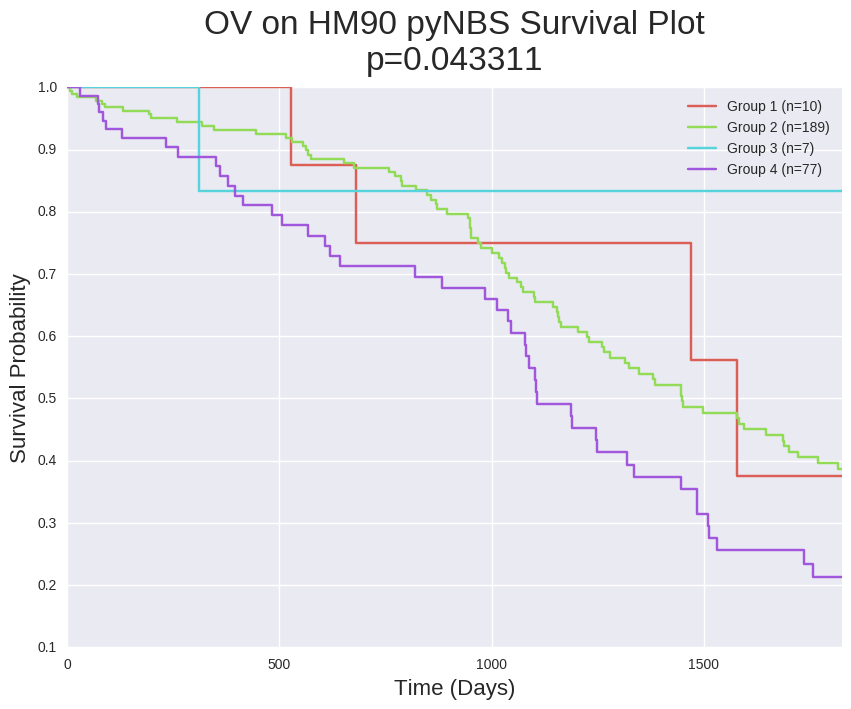

In [19]:
# Load survival Data
surv_data = './Example_Notebook_Data/Clinical_Files/OV.clin.merged.Hofree.txt'

# Plot KM Plot for patient clusters
plot.cluster_KMplot(NBS_cluster_assign, surv_data, delimiter=',', **save_args)
Image(filename = pyNBS_params['outdir']+pyNBS_params['job_name']+'_KM_plot.png', width=600, height=600)

# pyNBS Result comparison to Hofree et al 2013
We also compare the pyNBS clustering results against the original Hofree 2013 cluster assignments of the same patient data using two scores: adjusted rand index and adjusted mutual information score.
  
__Adjusted Rand Index (ARI)__
> Rand index adjusted for chance.
$$ARI = \frac{RI - \mathbb{E}(RI)}{ \max(RI) - \mathbb{E}(RI)}$$

__Adjusted Mutual Info Score (AMI)__
> Adjusted Mutual Information between two clusterings.
$${AMI(U, V) = \frac{MI(U, V) - \mathbb{E}(MI(U, V))}{\max(H(U), H(V)) - \mathbb{E}(MI(U, V))}}$$

In [20]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score

In [21]:
adj_rand_index = adjusted_rand_score(Hofree_OV_clust, pyNBS_OV_clust)
adj_mutual_info_score = adjusted_mutual_info_score(Hofree_OV_clust, pyNBS_OV_clust)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.697439276339
Adjusted Mutual Info Score is: 0.619366109969
